In [1]:
import boto3
import json
import boto3
import re
import csv
import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader
import uuid
import time
import io
from io import BytesIO
import sys
from pprint import pprint

from IPython.display import Image, display
from PIL import Image as PImage, ImageDraw

In [2]:
!pip install amazon-textract-response-parser

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
role = get_execution_role()
#print("RoleArn: {}".format(role))

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'claims-process-textract'

### Unified Residential Loan Application (URLA1003) formPaystubW2 formBank statementCredit card statementMortgage NotePassport1099 INT form1099 DIV form1099 MISC form1099 R formEmployment verification letterMortgage Statement

In [4]:
# Document

documentName = "URLA-1003.pdf"

client = boto3.client(service_name='textract',
         region_name= 'us-east-1',
         endpoint_url='https://textract.us-east-1.amazonaws.com')
# process using image bytes
def calltextract(documentName): 

    with open(documentName, 'rb') as file:
            img_test = file.read()
            bytes_test = bytearray(img_test)
            print('Image loaded', documentName)

    # process using image bytes
    response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['FORMS'])

    return response

In [5]:
response= calltextract(documentName)
print(response)

Image loaded URLA-1003.pdf
{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 0.0, 'Y': 2.3409130278650991e-07}, {'X': 1.0, 'Y': 0.0}, {'X': 1.0, 'Y': 1.0}, {'X': 4.1850523757602787e-07, 'Y': 1.0}]}, 'Id': '165960fe-a91c-42ed-b28e-da0ce9827185', 'Relationships': [{'Type': 'CHILD', 'Ids': ['1cd9c122-c1bd-47ca-ba3e-e03e26d59513', '70a5c531-7f7a-4993-bba0-d29912885b0e', 'bbe4e80d-93b1-441e-9e75-bb1c0c1d1daa', 'e62104bd-94a3-41ba-beef-1dca1efb5028', 'e05bf657-182f-4710-ab7e-0b915586aa02', '17cfb226-137f-46db-9b8d-e8cf6fd83a0f', '07a7680f-04cf-4e8d-a646-f1de6b6a4170', '76e12e7a-400b-4d06-a5b8-9cae5e9be1a5', '97c1ffee-b463-4c5e-abd9-520dc000f47b', 'cf37167d-369d-4c18-a4e3-632bab98acfb', 'a165ff6c-268c-4032-9965-5ef27e8d54f1', 'cb497d73-62b1-4740-b867-61efa480075e', '7a1d3c7c-3845-4500-8115-346b0b0e0511', 'd7af7312-eaf2-41ef-a017-475ca9aa35a3', '928475c8-d559-4ebb-af41-f9865f

In [6]:
#Extract key values
# Iterate over elements in the document
from trp import Document
def getformkeyvalue(response):
    doc = Document(response)
    
    key_map = {}
    for page in doc.pages:
        # Print fields
        for field in page.form.fields:
            if field is None or field.key is None or field.value is None:
                continue
        
            key_map[field.key.text] = field.value.text
    return key_map

In [7]:
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

{'Fee Simple': 'SELECTED', 'Subject Property Address (street, city, state, & ZIP)': '28777 Amos Lock, Markfurt, HI 71418', 'Secondary Residence': 'NOT_SELECTED', 'Amount Existing Liens': '$', 'Refinance': 'NOT_SELECTED', 'made': 'NOT_SELECTED', 'Separated': 'NOT_SELECTED', 'Construction': 'NOT_SELECTED', 'Leasehold(show expiration date)': 'NOT_SELECTED', 'Own': 'NOT_SELECTED', 'Interest Rate': '2.89 %', 'Lender Case Number': '58432890-8', 'USDA/Rural Housing Service': 'NOT_SELECTED', 'FHA': 'NOT_SELECTED', '(b) Cost of Improvements': '$', 'Conventional': 'SELECTED', 'Unmarried (includes single, divorced, widowed)': 'NOT_SELECTED', 'Yrs. School': '16', 'to be made': 'NOT_SELECTED', '(a) Present Value of Lot': '$', 'Purchase': 'SELECTED', 'Original Cost': '$', 'Fixed Rate': 'SELECTED', 'Title will be held in what Name(s)': 'Alejandro Rosalez', 'No. of Months': '360', 'Amount': '$ 450,000.00', "Borrower's Name (include Jr. or Sr. if applicable)": 'Alejandro Rosalez', 'Social Security Numb

In [8]:
response = None
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

    # Call Textract
    response = client.analyze_document(
        Document={'Bytes': imageBytes},
        # new QUERIES Feature Type for Textract Queries
        # We could add additional Feature Types like FORMS and/or TABLES
        # FeatureTypes=["QUERIES", "FORMS", "TABLS"],
        FeatureTypes=["QUERIES"],
        QueriesConfig={
            "Queries": [{
                "Text": "What is the prefered language?",
                "Alias": "LANGUAGE"
            }
        ]
        })
    print(response)

{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 0.0, 'Y': 2.3409130278650991e-07}, {'X': 1.0, 'Y': 0.0}, {'X': 1.0, 'Y': 1.0}, {'X': 4.1850523757602787e-07, 'Y': 1.0}]}, 'Id': '856c0373-4f86-429d-8d34-e38c75d44199', 'Relationships': [{'Type': 'CHILD', 'Ids': ['e28deb51-bf21-48e8-b43e-55ba1c35d6ef', 'cbc97c90-71ff-45c4-ab26-0a42facc4c57', 'b0eddb56-236a-4023-9145-92756cbfbc8a', '869ff64c-c4d3-401b-8853-13e43c2f5130', '8c481585-443d-44e9-935a-9388f1139bc0', 'b83bbad0-3137-4cbe-a967-9d239d147184', '51a192f1-3203-431e-a996-de0ab7ab72e5', '78e5a001-19aa-407a-a8b3-d700cf36d515', '55e34826-6177-4782-8f44-5071c511787d', '3cd1781d-789d-450a-91c6-63e0174838ff', 'd2dee0d5-798b-4a8d-a732-874e7f45a772', 'de7a9f2e-662f-4d21-8d03-5e358127cac7', '45c0672a-0b86-430f-bfaa-48c3464ba8a0', 'e8f76df6-ad19-4657-bddb-d7edaaa1a68e', '8f2eb4d9-8add-4b05-abe2-0f46e9049d18', '71944e00-bb25-437

#### Bank Statement

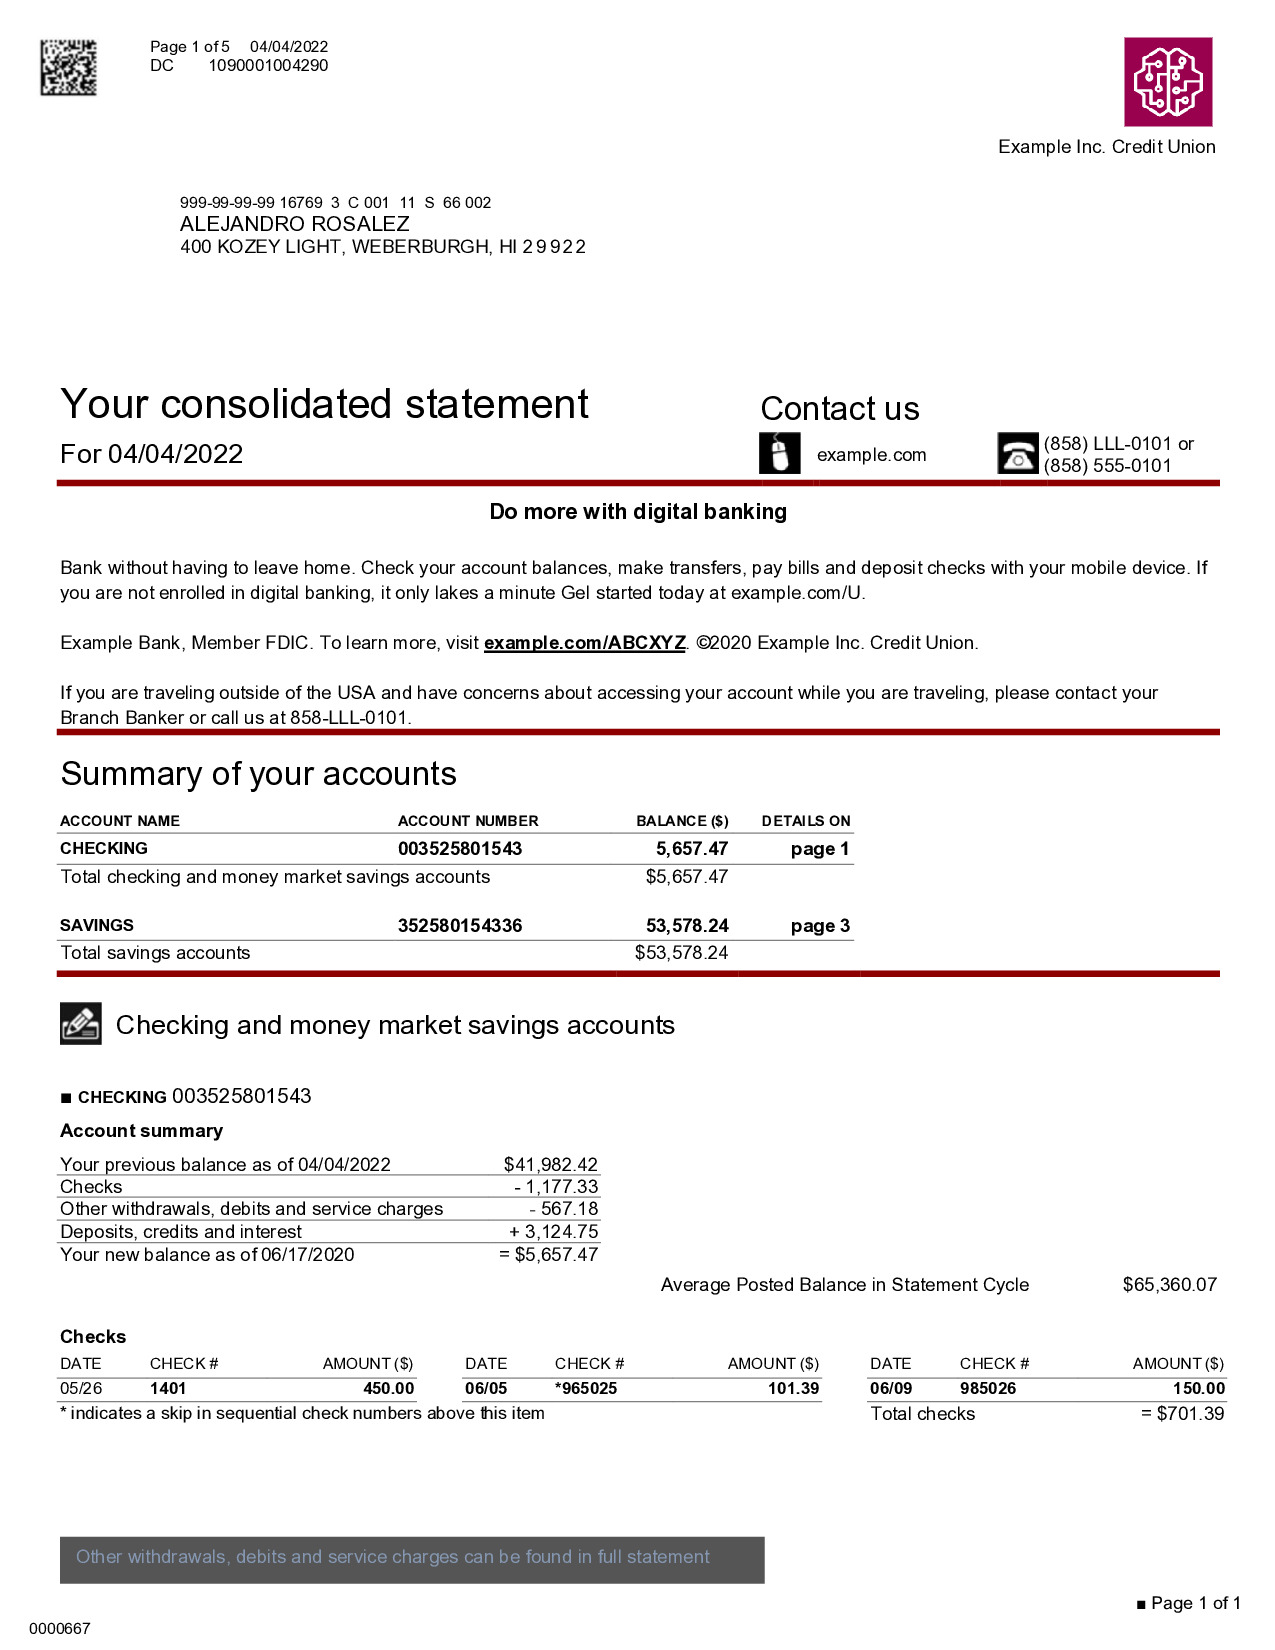

In [9]:
# Document

documentName = "Bank-Statement.jpg"

display(Image(filename=documentName))

In [10]:
response= calltextract(documentName)
#print(response)
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

Image loaded Bank-Statement.jpg
{'Deposits, credits and interest': '+ 3,124.75', 'Other withdrawals, debits and service charges': '- 567.18', 'CHECK #': '1401', 'Checks': '- 1,177.33', 'AMOUNT ($)': '150.00', 'Your new balance as of 06/17/2020': '= $5,657.47', 'Your previous balance as of 04/04/2022': '$41,982.42', 'DATE': '05/26', 'Average Posted Balance in Statement Cycle': '$65,360.07', 'DC': '1090001004290', 'DETAILS ON': 'page 1', 'Example Inc.': 'Credit Union', 'CHECKING': '003525801543', 'Total savings accounts': '$53,578.24', 'ACCOUNT NUMBER': '003525801543', 'ACCOUNT NAME': 'CHECKING', 'BALANCE ($)': '5,657.47'}


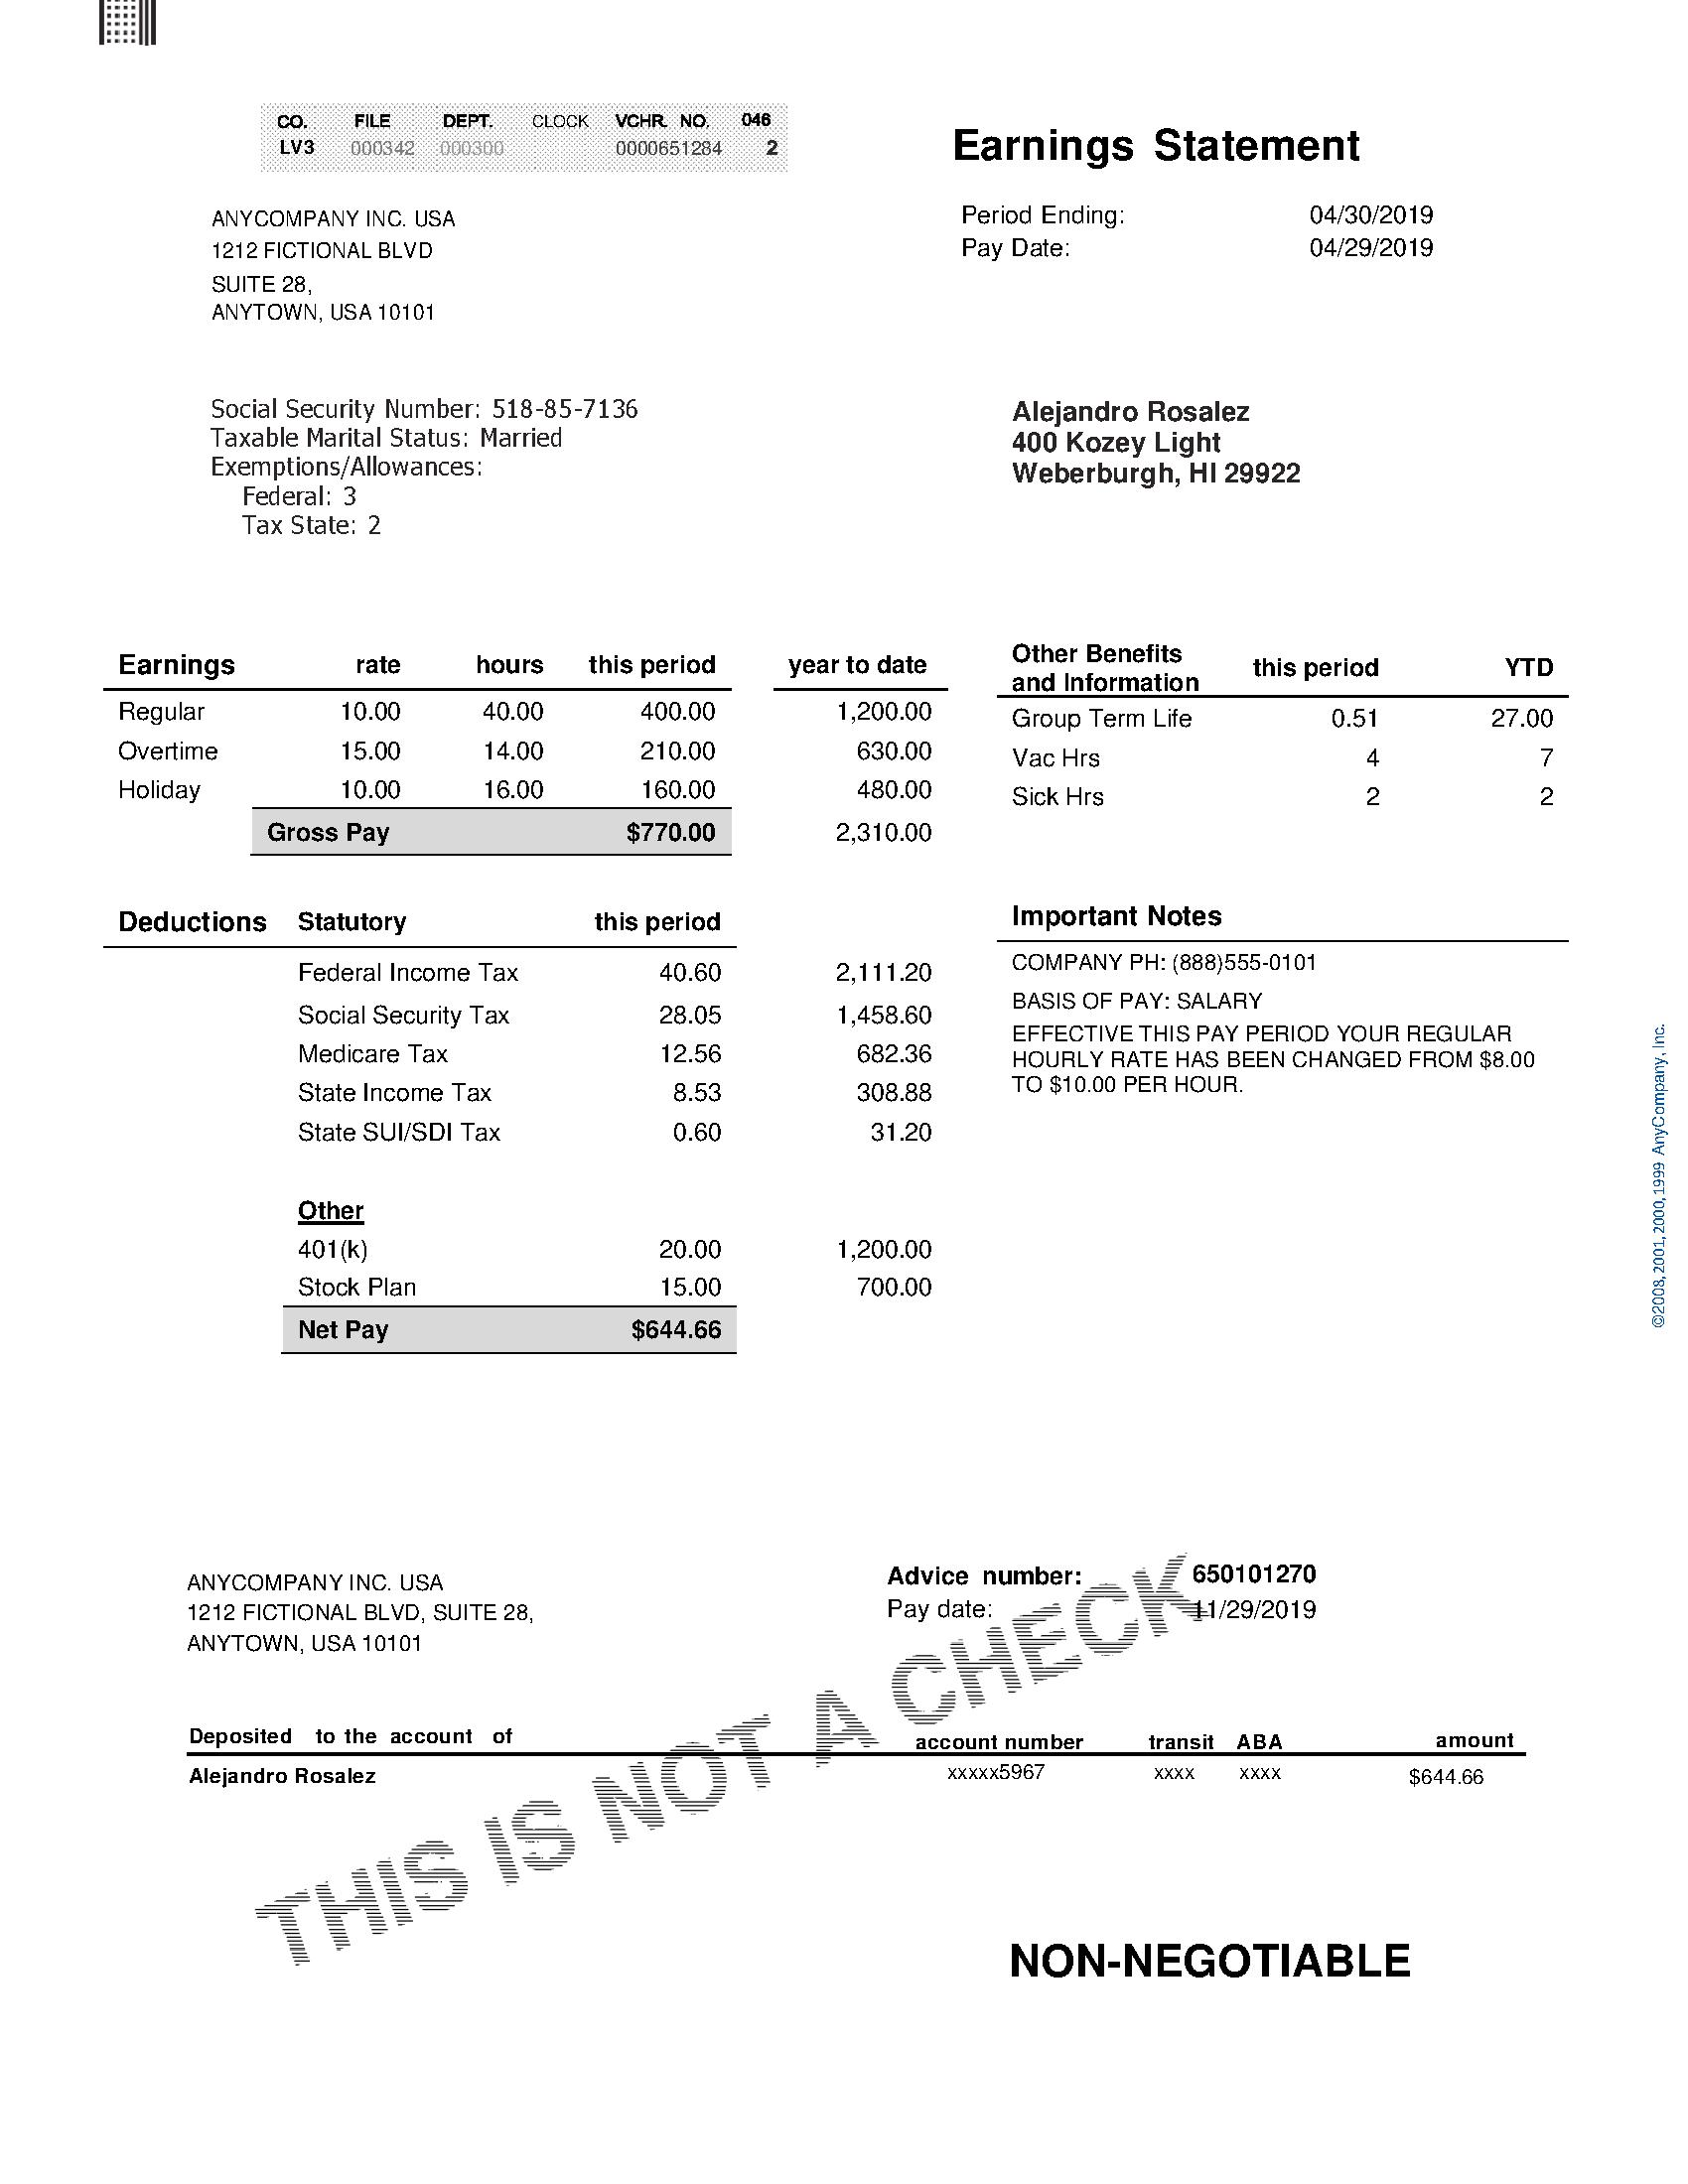

In [12]:
# Document

documentName = "Paystub.jpg"

display(Image(filename=documentName))

In [13]:
response= calltextract(documentName)

get_form_keys = getformkeyvalue(response)
print(get_form_keys)

Image loaded Paystub.jpg
{'Pay Date:': '04/29/2019', 'Advice number:': '650101270', 'Federal:': '3', 'Period Ending:': '04/30/2019', 'Social Security Number:': '518-85-7136', 'Tax State:': '2', 'Pay date:': '11/29/2019', 'account number': 'xxxxx5967', 'amount': '$644.66', 'Taxable Marital Status:': 'Married', 'transit ABA': 'XXXX XXXX', 'CO.': 'LV3', 'DEPT.': '000300', 'COMPANY PH:': '(888)555-0101', 'FILE': '000342', 'Deposited to the account of': 'Alejandro Rosalez', 'VCHR NO.': '0000651284', 'Net Pay': '$644.66', 'BASIS OF PAY:': 'SALARY', 'Gross Pay': '$770.00'}


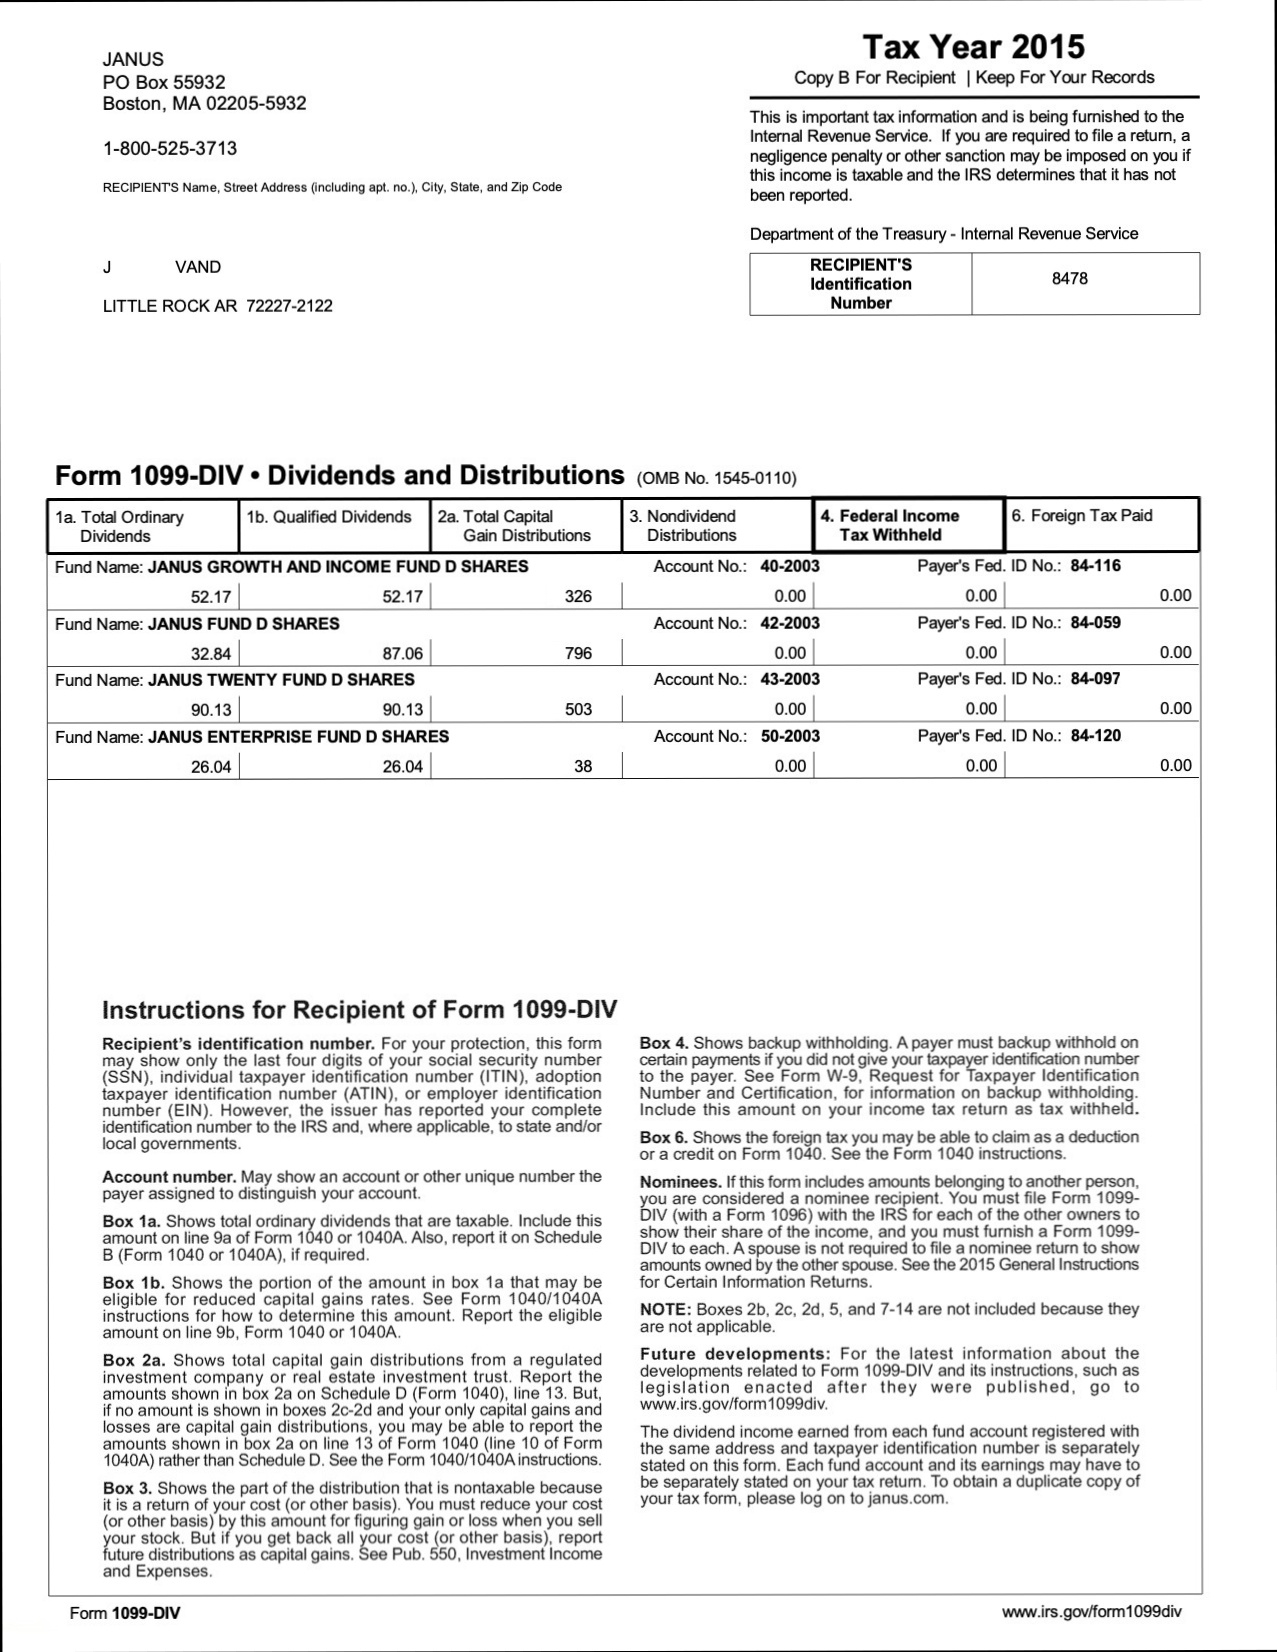

In [14]:
# Document

documentName = "1099-DIV.jpg"

display(Image(filename=documentName))

In [15]:
response= calltextract(documentName)

get_form_keys = getformkeyvalue(response)
print(get_form_keys)

Image loaded 1099-DIV.jpg
{'Account No.:': '40-2003', 'RECIPIENTS Name, Street Address (including apt. no.), City, State, and Zip Code': 'J VAND LITTLE ROCK AR 72227-2122', "RECIPIENT'S Identification Number": '8478', "Payer's Fed. ID No.:": '84-116', 'Fund Name:': 'JANUS ENTERPRISE FUND D SHARES'}


### Passport extraction with AnalyzeID

In [16]:
# Document

documentName = "Passport.pdf"

with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

response = client.analyze_id(
    DocumentPages=[{"Bytes":imageBytes}]
)

print(json.dumps(response, indent=2))

{
  "IdentityDocuments": [
    {
      "DocumentIndex": 1,
      "IdentityDocumentFields": [
        {
          "Type": {
            "Text": "FIRST_NAME"
          },
          "ValueDetection": {
            "Text": "ROSALEZ",
            "Confidence": 98.4963607788086
          }
        },
        {
          "Type": {
            "Text": "LAST_NAME"
          },
          "ValueDetection": {
            "Text": "ALEJANDRO",
            "Confidence": 99.01215362548828
          }
        },
        {
          "Type": {
            "Text": "MIDDLE_NAME"
          },
          "ValueDetection": {
            "Text": "",
            "Confidence": 99.6843490600586
          }
        },
        {
          "Type": {
            "Text": "SUFFIX"
          },
          "ValueDetection": {
            "Text": "",
            "Confidence": 99.65849304199219
          }
        },
        {
          "Type": {
            "Text": "CITY_IN_ADDRESS"
          },
          "ValueDetection": 

### Extraction with Query

In [17]:
# Document

documentName = "Paystub.jpg"
response= calltextract(documentName)
response = None
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

    # Call Textract
    response = client.analyze_document(
        Document={'Bytes': imageBytes},
        # new QUERIES Feature Type for Textract Queries
        # We could add additional Feature Types like FORMS and/or TABLES
        # FeatureTypes=["QUERIES", "FORMS", "TABLS"],
        FeatureTypes=["QUERIES"],
        QueriesConfig={
            "Queries": [{
                "Text": "What is the gross pay",
                "Alias": "GROSS_PAY"
            },
            {
                "Text": "What is the net pay?",
                "Alias": "NET_PAY"
            }
                
        ]
        })
    print(response)

Image loaded Paystub.jpg
{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 0.0, 'Y': 0.0}, {'X': 1.0, 'Y': 0.00015229219570755959}, {'X': 1.0, 'Y': 1.0}, {'X': 1.635820154888279e-07, 'Y': 1.0}]}, 'Id': 'c29f9933-8b3d-4c64-8218-dd2943fe0d9a', 'Relationships': [{'Type': 'CHILD', 'Ids': ['e2f169c7-3a65-481f-896f-31f9bc4ce57f', '240c3e49-d455-4c35-8130-cc6e97e8181b', 'a15649e1-f5d6-42ca-abb2-a17abc08df73', 'f80b0dba-52ce-4d72-ae97-21d92339b738', '99f9c0cc-bac9-426c-b5ce-e744cbb6105c', '36988638-8555-414c-9ab9-2d4d45f33bef', '03a5715c-0118-4bc6-ab3d-56d6690f0f98', '07d11fae-c289-424c-8052-91759a503147', '9f0265fd-ce88-4f5f-9a2e-71f31020e353', '95526abb-acbb-4fd1-8cf0-a17d79de3433', '14458756-584a-4d4b-acdc-a063135a113b', '2294403d-5aa6-4867-9198-01453ff3b20f', '4a37dc4f-edb4-466e-8f6b-55d60f67f800', 'ec0847e2-c9aa-4ef2-acba-f6ddda1a30d9', '81689529-b2f8-4b6d-88b1-bf6404b0e

### Extraction with Comprehend

In [18]:
documentName = "Paystub.jpg"
response= calltextract(documentName)
print(response)

Image loaded Paystub.jpg
{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 0.0, 'Y': 0.0}, {'X': 1.0, 'Y': 0.00015229219570755959}, {'X': 1.0, 'Y': 1.0}, {'X': 1.635820154888279e-07, 'Y': 1.0}]}, 'Id': 'bc92513f-469c-4977-9d4b-71a4404e0157', 'Relationships': [{'Type': 'CHILD', 'Ids': ['b069b8c1-5a8b-4660-8e41-447efd2ecafc', '6c7422ad-975e-4fbf-ae4f-d93e3c4fd2fd', '90185b62-a55c-4f5c-b3b2-e7a470fc76dd', '7e1184eb-15c6-4311-a5f9-0ae50e1e2369', '3a66aa03-0d0d-4a9c-97de-9239a6599644', 'f7cd7943-4c7c-496e-b041-049f5fe04f9c', '95aae868-8183-4081-9317-7531e23b0cd7', '388e7f81-4c78-4deb-83cc-dff4893f66ea', 'f359b246-9f4f-41fa-b0d7-4758d8305c95', '75d9cd36-90fa-45ce-88f2-943dff5b411c', 'e2cc86dc-9b45-4a6d-a3ba-9636593f322b', '6cf18289-5f4b-4b12-96a0-6861d1c8eb68', 'b6299ebf-22ea-41d6-a82e-a528c25013e2', 'b47a1e2a-f50c-4a78-a777-3266be1b1dbf', '14118b53-3f9a-4cb2-aa2b-cf461518f

In [19]:
# Print detected text
text = ""       
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        text = text + " " + item["Text"]


CO.
FILE
DEPT.
CLOCK VCHR NO.
046
LV3
000342
000300
0000651284
2
Earnings Statement
ANYCOMPANY INC. USA
Period Ending:
04/30/2019
1212 FICTIONAL BLVD
Pay Date:
04/29/2019
SUITE 28,
ANYTOWN, USA 10101
Social Security Number: 518-85-7136
Alejandro Rosalez
Taxable Marital Status: Married
400 Kozey Light
Exemptions/Allowances:
Weberburgh, HI 29922
Federal: 3
Tax State: 2
hours
Other Benefits
Earnings
rate
this period
year to date
this period
YTD
and Information
Regular
10.00
40.00
400.00
1,200.00
Group Term Life
0.51
27.00
Overtime
15.00
14.00
210.00
630.00
Vac Hrs
4
7
Holiday
10.00
16.00
160.00
480.00
Sick Hrs
2
2
Gross Pay
$770.00
2,310.00
Deductions Statutory
this period
Important Notes
Federal Income Tax
40.60
2,111.20
COMPANY PH: (888)555-0101
BASIS OF PAY: SALARY
Social Security Tax
28.05
1,458.60
EFFECTIVE THIS PAY PERIOD YOUR REGULAR
Medicare Tax
12.56
682.36
HOURLY RATE HAS BEEN CHANGED FROM $8.00
State Income Tax
8.53
308.88
TO $10.00 PER HOUR.
State SUI/SDI Tax
0.60
31.20
Other


## Enrichment - Document Processing - PII Detection

In [22]:
documentName = "Passport.pdf"
response= calltextract(documentName)
# Print detected text
text = ""       
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        text = text + " " + item["Text"]


Image loaded Passport.pdf
PASSPORT
UNITED STATES OF AMERICA
PASSEPORT
Type/Type/Tipo Code/Code/Codigo
Passport No./ No. du Passeport / No. de Passporte
PASSPORTE
P USA
918268822
Surname / Nom / Appelidos
USA
Alejandro
Given Names / Prénoms / Nombres
Rosalez
Nationality /Nationalité/Nacionalidad
UNITED STATES OF AMERICA
Date of birth / Date de naissance / Fecha de nacimiento
15 Apr 1990
Place of birth / Lieu de naissance / Lugar de nacimiento
Sex / Sexe / Sexo
Texas, U.S.A.
M
Date of issue / Date de délivrance / Fecha de expedición
Authority / Autorité / Autoridad
29 Jan 2009
United States
Date of expiration / Date d'expiration / Fecha de caducidad
31 Jan 2029
Department of State
Endorsements / Mentions Speciales / Anotaciones
SEE PAGE 27
P<USAROSALEZ<<ALEJANDRO<<<<<<<<<<<<<<<<<<<<<<
349587345029USA1209381M2394820392344059<1 < 834983457
